In [326]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from scipy.spatial.distance import cosine
import zipfile
import itertools
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
################################ CONDITION MAPPINGS ################################ 

#Idea: we create a customised event_id dict that allows us to later just extract 
    # the trailing images corresponding to our transitional probabiliy categories

    # Mapping VALID CONDITIONS (75%): 
        # leading_barn -> trailing_church
        # leading_beach -> trailing_church
        # leading_library -> trailing_conference_room
        # leading_restaurant ->  trailing_conference_room

    # Mapping INVALID CONDITIONS (25%): 
        # leading_barn -> trailing_conference_room
        # leading_beach -> trailing_conference_room
        # leading_library -> trailing_church
        # leading_restaurant -> trailing_church
        
    # Mapping CONTROL CONDITIONS (50%): 
        # leading_cave -> trailing_castle
        # leading_cave -> trailing_forest
        

# Create label_dict according to labels used during training
label_dict = {
    (0, 1): 0.75, (1, 1): 0.75,
    (3, 2): 0.75, (4, 2): 0.75,
    (0, 2): 0.25, (1, 2): 0.25,
    (3, 1): 0.25, (4, 1): 0.25,
    (2, 0): 0.5,
    (2, 3): 0.5
}

# Leading dict
lead_dict = {
    "barn": 0,
    "beach": 1,
    "cave": 2,
    "library": 3,
    "restaurant": 4
}

# Trailing dict
trail_dict = {
    "Church": 1,
    "castle": 0,
    "conference_room": 2,
    "forest": 3
}

# Dict for RDM mappings
rdm_dict = {
    0: ((0, 1), (1, 1)),  # 0.75%: barn -> church, beach -> church
    1: ((3, 2), (4, 2)),  # 0.75%: library -> conference room, restaurant -> conference room
    2: ((0, 2), (1, 2)),  # 0.25%: barn -> conference room, beach -> conference room
    3: ((3, 1), (4, 1)),  # 0.25%: library -> church, restaurant -> church
    4: ((2, 0),),         # 0.5%: cave -> castle
    5: ((2, 3),)          # 0.5%: cave -> forest
}


category_dict = {
    0: (0, 5), # valid conditions 75 %
    1: (1, 5), # leading_beach -> trailing_church
    2: (2, 6), # leading_library -> trailing_conference_room
    3: (3, 6),  # leading_restaurant ->  trailing_conference_room
    4: (0, 6), # invalid conditions 0.25 %
    5: (1, 6),
    6: (2, 5), 
    7: (3, 5), 
    8: (4, 7), # control conditions 50 %
    9: (4, 8)
}





In [ ]:
################################ HELPER FUNCTIONS ################################ 

def generate_possible_img_pairings(rdm_dict, category_id, img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size=(28, 28), seed=None):
    '''This function generates a dataset with all possible image combinations based on rdm_dict.'''

    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1,
        label_mode='int',
        class_names=class_namest1,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2,
        label_mode='int',
        class_names=class_namest2,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )


    l_data_t1 = list(data_t1)
    l_data_t2 = list(data_t2)


    x_pairs = []
    y_labels = []

    # Generate pairs for the specified category_id
    if category_id in rdm_dict:
        pairs = rdm_dict[category_id]
        for lead, trail in pairs:
            # Filter images by label in data_t1 and data_t2 for the current lead and trail categories
            lead_images = [img for img, lbl in l_data_t1 if lbl.numpy() == lead]
            trail_images = [img for img, lbl in l_data_t2 if lbl.numpy() == trail]

            # Generate all possible combinations of image pairs according to current leading and trailing image category
            for img_t1, img_t2 in itertools.product(lead_images, trail_images):
                # Concatenate images along the height dimension -> (56, 28, 3)
                x = tf.concat([img_t1, img_t2], axis=0)  
                label = label_dict[(lead, trail)] 
                y = tf.cast(tf.random.uniform([]) < label, tf.float32) 
                y = tf.expand_dims(y, axis=0) 

                x_pairs.append(x)  
                y_labels.append(y)  

    # Concatenate all pairs and the correspondin labels  
    x_stacked = tf.concat([tf.expand_dims(x, axis=0) for x in x_pairs], axis=0)
    y_stacked = tf.concat([tf.expand_dims(y, axis=0) for y in y_labels], axis=0)
    
    return tf.data.Dataset.from_tensors((x_stacked, y_stacked))
  

def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def img_preproc(x, y, dtype=tf.float32): 
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y):  
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not (batch_size, n_steps, height, width, channels)
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4: # regular image (batch_size, height, width, channels)
    x = tf.reshape(x, [shape[0], -1])
  elif len(shape) == 3:  # Single image (height, width, channels)
    x = tf.reshape(x, [-1])
  return x, y


In [ ]:
################################ RELOAD PCN ################################ 

# To reload the PCN, we need to call the model once again and nee the specific customed Dense layer model itself. 

class CustomDense(tf.keras.layers.Dense):
    def call(self, inputs):
        """This works like a dense, except for the activation being called earlier."""
        # Apply the activation to the input first
        activated_input = self.activation(inputs)
        # Perform the matrix multiplication and add the bias
        output = tf.matmul(activated_input, self.kernel)
        if self.use_bias:
            output = output + self.bias
        return output


class PredictiveCodingNetwork(tf.keras.Sequential):
    def __init__(self, layers, vars, beta, **kwargs):
        """Initialize a PredictiveCodingNetwork"""
        super().__init__(layers, **kwargs)
        self.vars = tf.convert_to_tensor(vars, dtype=tf.float32)
        self.beta = beta

    def call_with_states(self, x):
        x_list = [x]
        for layer in self.layers:
            x = layer(x)
            x_list.append(x)
        return x_list

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        # do the stuff we do in train_epochs
        outputs, errors = self.infer(x, y)
        self.update_params(outputs, errors)

        # Update metrics (includes the metric that tracks the loss)
        pred = self.call(x)
        for metric in self.metrics:
            metric.update_state(y, pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
   
    def infer(self, x_batch, y_batch=None, n_iter=50, return_sequence=False):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        if return_sequence:
            errors_time = []
            states_time = []
        errors = [None for _ in range(len(self.layers))]
        f_x_arr = [None for _ in range(len(self.layers))]
        f_x_deriv_arr = [None for _ in range(len(self.layers))]
        shape = x_batch.shape
        batch_size = shape[0]

        for itr in range(n_iter):
            # if its the first itr, set x to the current forward call
            if itr == 0:
                x = self.call_with_states(x_batch)

                if y_batch is not None:
                  x[-1] = y_batch
            else:
                # update g and x only for consecutive iterations
                for l in range(1, len(self.layers)):
                    g = tf.multiply(tf.matmul(errors[l], self.layers[l].kernel, transpose_b=True), f_x_deriv_arr[l])
                    x[l] = x[l] + self.beta * (-errors[l-1] + g)

            # update f_x etc for every iteration
            for l in range(len(self.layers)):
                f_x = self.layers[l].activation(x[l])
                f_x_deriv_fn = self.get_activation_derivative(self.layers[l].activation)
                f_x_deriv = f_x_deriv_fn(x[l])
                f_x_arr[l] = f_x
                f_x_deriv_arr[l] = f_x_deriv
                errors[l] = (x[l + 1] - tf.matmul(f_x, self.layers[l].kernel) - self.layers[l].bias) / self.vars[l]
            
            if return_sequence:
                errors_time.append(errors)
                states_time.append(x)

        # return what we want to return
        if return_sequence:
            states_time = [tf.stack(tensors, axis=1) for tensors in zip(*states_time)]
            errors_time = [tf.stack(tensors, axis=1) for tensors in zip(*errors_time)]
            return states_time, errors_time
        else:
            return x, errors
    
    # We need to check if we actually need call here.
    # Now, call will give us the result of the network after the first inference step
    # If we want to have the results after the last inference step, we would need to change this
    #def call(self, inputs, training=False):
    #    """Call, but time distributed."""
    #    x, errors = self.infer(inputs, return_sequence=False)
    #    return x[-1]

    def update_params(self, x, errors):
        """Update the model parameters."""
        batch_size = tf.cast(tf.shape(x[0])[0], tf.float32)
        gradients = []
        for l, layer in enumerate(self.layers):
            grad_w = self.vars[-1] * (1 / batch_size) * tf.matmul(tf.transpose(self.layers[l].activation(x[l])), errors[l])
            grad_b = self.vars[-1] * (1 / batch_size) * tf.reduce_sum(errors[l], axis=0)
            gradients.append((-grad_w, layer.kernel))
            gradients.append((-grad_b, layer.bias))
        self.optimizer.apply_gradients(gradients)

    def get_activation_derivative(self, activation):
        """Return a function for the derivative of the given activation function."""
        activation_fn = tf.keras.activations.get(activation)
        if activation_fn == tf.keras.activations.linear:
            return lambda x: tf.ones_like(x)
        elif activation_fn == tf.keras.activations.tanh:
            return lambda x: 1 - tf.square(tf.nn.tanh(x))
        elif activation_fn == tf.keras.activations.sigmoid:
            return lambda x: tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
        else:
            raise ValueError(f"{activation} not supported")
        
def call_with_states(model, x):
     outputs = []
     for layer in model.layers:
          x = layer(x)
          outputs.append(x)
     return outputs
        

In [298]:
################################ MODEL PATHS ################################ 
dir_bpann = "/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_649_0.67.keras"
dir_pcn = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_726_0.67.keras"
unzip_path = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/pcn_tt/"

In [ ]:
################################ LOAD ANNs ################################ 
input_layer = tf.keras.layers.Input(shape=(4704,))

model = PredictiveCodingNetwork([CustomDense(units=6, activation="sigmoid"),
                                 CustomDense(units=4, activation="sigmoid"), 
                                 CustomDense(units=1, activation="sigmoid")], 
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)

keras_file_path = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_726_0.67.keras"
unzip_path = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/pcn_tt/"

with zipfile.ZipFile(keras_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Step 2: Instantiate your custom model with the correct parameters
pcn = model # PCN loaded after reinitialising the network

# Now `correct_model` has the loaded weights
pcn.build([None, 4704])
pcn.load_weights("/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/pcn_tt/model.weights.h5")

pcn.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2),
    loss="categorical_crossentropy",  # Placeholder loss
    metrics=["accuracy"]
)


# Backprop ANN
bp_ann = tf.keras.models.load_model(dir_bpann)

# Some random checks 
#pcn.infer(tf.random.normal([64, 4704]), return_sequence=True)
#[[i.shape for i in j] for j in pcn.infer(tf.random.normal([64, 4704]), return_sequence=True)]
# bp_ann(tf.random.normal([64, 4704]))


In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

# Initialize the RDM matrix
category_ids = len(rdm_dict)
rdm_h1_pcn_act = np.zeros((6,6))

# Dictionary to cache mean activations for each category
category_activations = []

# Calculate and cache mean activations for each category only once
for category_id in range(category_ids):
    print(f"Processing category_id: {category_id}")
    
    # Generate possible image pairings for the given category without creating a batch
    val_dataset = generate_possible_img_pairings(
        rdm_dict, category_id, img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size=(28, 28), seed=seed
    )

    # Preprocess and flatten the dataset without batching
    val_dataset = val_dataset.map(img_preproc).map(flatten)

    # Retrieve all image pairs and labels in the dataset (assuming a single batch dataset)
    x_pairs, y_labels = next(iter(val_dataset))

    # Predict activations for the current category's image pairs
    pcn_acts = correct_model.predict(x_pairs)

    # Calculate and store the mean activation for this category
    mean_activation = np.mean(pcn_acts, axis=0).reshape(-1)
    category_activations.append(mean_activation)  # Store the exact vector used for all comparisons

# Calculate cosine similarities between the mean activations to populate the RDM
for i in range(category_ids):
    for j in range(category_ids):
        arr_i = category_activations[i]
        arr_j = category_activations[j]
        rdm_h1_pcn_act[i, j] = cosine(arr_i, arr_j)

        # Calculate cosine similarity between the mean activations
        #rdm_h1_pcn_act[i, j] = cosine(mean_activation_i, mean_activation_j)

# Display the RDM matrix
print("RDM Matrix:")
print(rdm_h1_pcn_act)


Processing category_id: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Processing category_id: 1
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing category_id: 2
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing category_id: 3
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing category_id: 4
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Processing category_id: 5
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RDM Matrix:
[[0.00000000e+00 3.88539038e-08 0.00000000e+00 0.00000000e+00
  3.75434434e-08 1.48837525e-08]
 [3.88539038e-0

In [ ]:
################################ IMAGE PATHS ################################ 

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [436]:
################################ RESULT PATHS ################################ 
results_path_pcn = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/"
results_path_bp = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/backprop/"

In [357]:
label_dict = {
    (0, 1): 0.0, (1, 1): 0.0,
    (3, 2): 0.0, (4, 2): 0.0,
    (0, 2): 0.75, (1, 2): 0.75,
    (3, 1): 0.75, (4, 1): 0.75,
    (2, 0): 0.5,
    (2, 3): 0.5
}

lead_cat = {
    "barn": 0,
    "beach": 1,
    "cave": 2,
    "library": 3,
    "restaurant": 4
}

trail_cat = {
    "church": 1,
    "castle": 0,
    "conference_room": 2,
    "forest": 3
}

rdm_dict = {
    0: ((0, 1), (1, 1)),  # 0.75%: barn -> church, beach -> church
    1: ((3, 2), (4, 2)),  # 0.75%: library -> conference room, restaurant -> conference room
    2: ((0, 2), (1, 2)),  # 0.25%: barn -> conference room, beach -> conference room
    3: ((3, 1), (4, 1)),  # 0.25%: library -> church, restaurant -> church
    4: ((2, 0),),         # 0.5%: cave -> castle
    5: ((2, 3),)          # 0.5%: cave -> forest
}



# Generator function to produce specific combinations as defined by rdm_dict
def generate_specific_combination(category_id, rdm_dict, img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size=(28, 28), seed=None): 
    # Load images from both directories without batching
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode='int',
        class_names=class_namest1,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )
    
    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode='int',
        class_names=class_namest2,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )
    
    # Convert datasets to lists for pairing
    data_t1_list = list(data_t1)
    data_t2_list = list(data_t2)

    x_pairs = []
    y_labels = []

    # Only process the specified category_id in rdm_dict
    if category_id in rdm_dict:
        pairs = rdm_dict[category_id]
        for lead, trail in pairs:
            # Filter images by label in data_t1 and data_t2 for the current lead and trail categories
            lead_images = [img for img, lbl in data_t1_list if lbl.numpy() == lead]
            trail_images = [img for img, lbl in data_t2_list if lbl.numpy() == trail]

            # Pair each lead image with each trail image
            for img_t1, img_t2 in itertools.product(lead_images, trail_images):
                # Concatenate images and assign labels based on label_dict
                x, y = img_sequence(img_t1, img_t2, lead, trail, label_dict)
                if x is not None:
                    x_pairs.append(x)
                    y_labels.append(y)

    # Stack pairs and labels if they exist
        x_stacked = tf.stack(x_pairs, axis=0)
        y_stacked = tf.stack(y_labels, axis=0)
        return x_stacked, y_stacked
    

Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Combined dataset - x shape: (3240, 56, 28, 3), y shape: (3240, 1)
Combined x shape: (3240, 56, 28, 3), Combined y shape: (3240, 1)


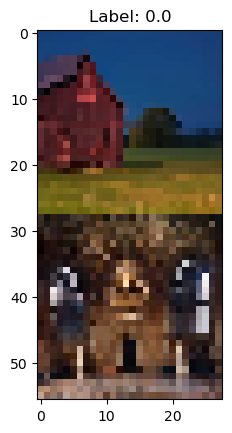

In [ ]:
def generate_possible_img_pairings(rdm_dict, category_id, img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size=(28, 28), seed=None):
    '''This function generates a dataset with all possible image combinations based on rdm_dict.'''

    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1,
        label_mode='int',
        class_names=class_namest1,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2,
        label_mode='int',
        class_names=class_namest2,
        batch_size=None,
        color_mode='rgb',
        image_size=image_size,
        seed=seed
    )


    l_data_t1 = list(data_t1)
    l_data_t2 = list(data_t2)


    x_pairs = []
    y_labels = []

    # Generate pairs for the specified category_id
    if category_id in rdm_dict:
        pairs = rdm_dict[category_id]
        for lead, trail in pairs:
            # Filter images by label in data_t1 and data_t2 for the current lead and trail categories
            lead_images = [img for img, lbl in l_data_t1 if lbl.numpy() == lead]
            trail_images = [img for img, lbl in l_data_t2 if lbl.numpy() == trail]

            # Generate all possible combinations of image pairs according to current leading and trailing image category
            for img_t1, img_t2 in itertools.product(lead_images, trail_images):
                # Concatenate images along the height dimension -> (56, 28, 3)
                x = tf.concat([img_t1, img_t2], axis=0)  
                label = label_dict[(lead, trail)] 
                y = tf.cast(tf.random.uniform([]) < label, tf.float32) 
                y = tf.expand_dims(y, axis=0) 

                x_pairs.append(x)  
                y_labels.append(y)  

    # Concatenate all pairs and the corresponding labels  
    x_stacked = tf.concat([tf.expand_dims(x, axis=0) for x in x_pairs], axis=0)
    y_stacked = tf.concat([tf.expand_dims(y, axis=0) for y in y_labels], axis=0)
    
    return x_stacked, y_stacked  

In [375]:
def call_with_states(model, x):
     outputs = []
     for layer in model.layers:
          x = layer(x)
          outputs.append(x)
     return outputs

In [ ]:
rdm_h1_pcn_act = np.zeros((6,6))
rdm_h1_pcn_err = np.zeros((6,6))
rdm_h1_bp = np.zeros((6,6))

rdm_h23_pcn_act_l1 = np.zeros((6,6))
rdm_h23_pcn_act_l2 = np.zeros((6,6))


category_ids = list(rdm_dict.keys())

for i, category_id_i in enumerate(category_ids):
    for j, category_id_j in enumerate(category_ids):
        
            
        
        # Create category specific image pairs
            print(f"Processing images from category_id_i: {category_id_i}")
            val_dataset_i = generate_possible_img_pairings(
                rdm_dict, category_id_i, img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size=(28, 28), seed=seed
            )
            
            print(f"Processing images from category_id_j: {category_id_j}")
            val_dataset_j = generate_possible_img_pairings(
                rdm_dict, category_id_j, img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size=(28, 28), seed=seed
            )
            
            # Preprocess and flatten images 
            val_dataset_i = flatten(*img_preproc(val_dataset_i[0], val_dataset_i[1]))[0] # only return images
            val_dataset_j = flatten(*img_preproc(val_dataset_j[0], val_dataset_j[1]))[0]
            
            # Generate and extract activations 
            pcn_acts_i, pcn_err_i = pcn.infer(val_dataset_i, return_sequence=True) # shape: (batch_size, n_iter, n_units) 
            pcn_acts_j, pcn_err_j = pcn.infer(val_dataset_j, return_sequence=True) # shape: (batch_size, n_iter, n_units) 
            
            pcn_acts_i = [tf.reshape(tensor, (tensor.shape[0], -1)) for tensor in pcn_acts_i] # flatten for later concat of all layers in the next step
            pcn_acts_j = [tf.reshape(tensor, (tensor.shape[0], -1)) for tensor in pcn_acts_j]
            pcn_err_i = [tf.reshape(tensor, (tensor.shape[0], -1)) for tensor in pcn_err_i]
            pcn_err_j = [tf.reshape(tensor, (tensor.shape[0], -1)) for tensor in pcn_err_j]
            
            
            bp_acts_i = call_with_states(bp_ann, val_dataset_i)
            bp_acts_j = call_with_states(bp_ann, val_dataset_j)

         
            # RDMs for H1
            rdm_h1_pcn_act[i, j] = cosine(np.mean(np.concatenate([layer for layer in pcn_acts_i[1:]], axis=1), axis=0), np.mean(np.concatenate([layer for layer in pcn_acts_j[1:]], axis=1), axis=0)) 
            rdm_h1_pcn_err[i,j] = cosine(np.mean(np.concatenate([layer for layer in pcn_err_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in pcn_err_j], axis=1), axis=0)) 
            rdm_h1_bp[i,j] = cosine(np.mean(np.concatenate([layer for layer in bp_acts_i[1:]], axis=1), axis=0), np.mean(np.concatenate([layer for layer in bp_acts_j[1:]], axis=1), axis=0)) 
            
            # RDMs for H2 & H3
            rdm_h23_pcn_act_l1[i,j] = cosine(np.mean(pcn_acts_i[1], axis=0), np.mean(pcn_acts_j[1], axis=0)) 
            rdm_h23_pcn_act_l2[i,j] = cosine(np.mean(pcn_acts_i[2], axis=0), np.mean(pcn_acts_j[2], axis=0))  
             
        

# Save RDMS
print(f"################################ Saving all ann-based RDMs now ################################")

np.save(os.path.join(results_path_pcn, "rdm_h1_pcn_act.npy"), rdm_h1_pcn_act)
np.save(os.path.join(results_path_pcn, "rdm_h1_pcn_error.npy"), rdm_h1_pcn_err)
np.save(os.path.join(results_path_bp, "rdm_h1_bp.npy"), rdm_h1_bp)
np.save(os.path.join(results_path_pcn, "rdm_h23_pcn_l1.npy"), rdm_h23_pcn_act_l1)
np.save(os.path.join(results_path_pcn, "rdm_h23_pcn_l2.npy"), rdm_h23_pcn_act_l2)

Processing images from category_id_i: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_j: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_i: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_j: 1
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_i: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_j: 2
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_i: 0
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_j: 3
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_i: 0


2024-11-11 18:22:22.135577: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing images from category_id_i: 5
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
Processing images from category_id_j: 5
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
################################ Saving all ann-based RDMs now ################################


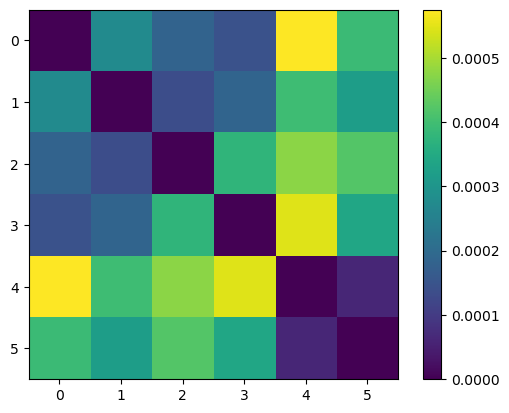

In [449]:
rdm = np.load("/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/ann_RDM/pcn/rdm_h1_pcn_act.npy")
plt.imshow(rdm, cmap='viridis') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.show()
plt.close()



In [45]:
################################ PCN NETWORK OBJECT ################################ 

class CustomDense(tf.keras.layers.Dense):
    def call(self, inputs):
        """This works like a dense, except for the activation being called earlier."""
        # Apply the activation to the input first
        activated_input = self.activation(inputs)
        # Perform the matrix multiplication and add the bias
        output = tf.matmul(activated_input, self.kernel)
        if self.use_bias:
            output = output + self.bias
        return output


class PredictiveCodingNetwork(tf.keras.Sequential):
    def __init__(self, layers, vars, beta, **kwargs):
        """Initialize a PredictiveCodingNetwork"""
        super().__init__(layers, **kwargs)
        self.vars = tf.convert_to_tensor(vars, dtype=tf.float32)
        self.beta = beta

    def call_with_states(self, x):
        x_list = [x]
        for layer in self.layers:
            x = layer(x)
            x_list.append(x)
        return x_list

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        # do the stuff we do in train_epochs
        outputs, errors = self.infer(x, y)
        self.update_params(outputs, errors)

        # Update metrics (includes the metric that tracks the loss)
        pred = self.call(x)
        for metric in self.metrics:
            metric.update_state(y, pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
   
    def infer(self, x_batch, y_batch=None, n_iter=50, return_sequence=False):
        """Note: while model call, call with states and model evaluate take
        2D input, train_step and infer take stacked 3D inputs."""
        if return_sequence:
            errors_time = []
            states_time = []
        errors = [None for _ in range(len(self.layers))]
        f_x_arr = [None for _ in range(len(self.layers))]
        f_x_deriv_arr = [None for _ in range(len(self.layers))]
        shape = x_batch.shape
        batch_size = shape[0]

        for itr in range(n_iter):
            # if its the first itr, set x to the current forward call
            if itr == 0:
                x = self.call_with_states(x_batch)

                if y_batch is not None:
                  x[-1] = y_batch
            else:
                # update g and x only for consecutive iterations
                for l in range(1, len(self.layers)):
                    g = tf.multiply(tf.matmul(errors[l], self.layers[l].kernel, transpose_b=True), f_x_deriv_arr[l])
                    x[l] = x[l] + self.beta * (-errors[l-1] + g)

            # update f_x etc for every iteration
            for l in range(len(self.layers)):
                f_x = self.layers[l].activation(x[l])
                f_x_deriv_fn = self.get_activation_derivative(self.layers[l].activation)
                f_x_deriv = f_x_deriv_fn(x[l])
                f_x_arr[l] = f_x
                f_x_deriv_arr[l] = f_x_deriv
                errors[l] = (x[l + 1] - tf.matmul(f_x, self.layers[l].kernel) - self.layers[l].bias) / self.vars[l]
            
            if return_sequence:
                errors_time.append(errors)
                states_time.append(x)

        # return what we want to return
        if return_sequence:
            states_time = [tf.stack(tensors, axis=1) for tensors in zip(*states_time)]
            errors_time = [tf.stack(tensors, axis=1) for tensors in zip(*errors_time)]
            return states_time, errors_time
        else:
            return x, errors
    
    # We need to check if we actually need call here.
    # Now, call will give us the result of the network after the first inference step
    # If we want to have the results after the last inference step, we would need to change this
    #def call(self, inputs, training=False):
    #    """Call, but time distributed."""
    #    x, errors = self.infer(inputs, return_sequence=False)
    #    return x[-1]

    def update_params(self, x, errors):
        """Update the model parameters."""
        batch_size = tf.cast(tf.shape(x[0])[0], tf.float32)
        gradients = []
        for l, layer in enumerate(self.layers):
            grad_w = self.vars[-1] * (1 / batch_size) * tf.matmul(tf.transpose(self.layers[l].activation(x[l])), errors[l])
            grad_b = self.vars[-1] * (1 / batch_size) * tf.reduce_sum(errors[l], axis=0)
            gradients.append((-grad_w, layer.kernel))
            gradients.append((-grad_b, layer.bias))
        self.optimizer.apply_gradients(gradients)

    def get_activation_derivative(self, activation):
        """Return a function for the derivative of the given activation function."""
        activation_fn = tf.keras.activations.get(activation)
        if activation_fn == tf.keras.activations.linear:
            return lambda x: tf.ones_like(x)
        elif activation_fn == tf.keras.activations.tanh:
            return lambda x: 1 - tf.square(tf.nn.tanh(x))
        elif activation_fn == tf.keras.activations.sigmoid:
            return lambda x: tf.nn.sigmoid(x) * (1 - tf.nn.sigmoid(x))
        else:
            raise ValueError(f"{activation} not supported")
        

model = PredictiveCodingNetwork([CustomDense(units=6, activation="sigmoid"),
                                 CustomDense(units=4, activation="sigmoid"), 
                                 CustomDense(units=1, activation="sigmoid")], 
                                vars=[1, 1, 1], # variances. This is super useless and in the code only the last variance is used
                                beta=0.1)



In [74]:
# Step 1: Unzip the .keras file to access its internal structure
keras_file_path = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/model_checkpoint_pcnoriginal_726_0.67.keras"
unzip_path = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/pcn_tt/"

with zipfile.ZipFile(keras_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Step 2: Instantiate your custom model with the correct parameters
correct_model = model # PCN loaded after reinitialising the network


# Now `correct_model` has the loaded weights
correct_model.build([None, 4704])
correct_model.load_weights("/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/pcn_tt/model.weights.h5")

correct_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-7, weight_decay=1e-2),
    loss="categorical_crossentropy",  # Placeholder loss
    metrics=["accuracy"]
)

# Predict states
predictions = correct_model.predict(val_dataset.batch(512).map(img_preproc).map(flatten))

# Evaluate the model
test_loss, test_accuracy = correct_model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step - accuracy: 0.6722 - loss: 3.9074e-08
Test Loss: 3.907416257220575e-08, Test Accuracy: 0.6722221970558167
